# Dataset Preparation

We start the ZINC20 database (https://zinc20.docking.org), a free database of commercially-available compounds for virtual screening. It is particulary attractive as it has many options to pre-filter ligands. We select molecules in this databased using the following conditions:

* Those that are lead-like (Mol wt. in the range of 300-350 and logP values of -1 to 3.5). These are designed to be less complex, with lower molecular weight, lower lipophilicity, and fewer hydrogen bond donors and acceptors compared to final drug candidates, allowing for greater chemical modification during the lead optimization process.
* Those are not just purchasable, but in-stock as well from major vendors.
* And those that have standard reactivity.

The SMILES data can be downloaded by running `download.wget`. 

In [1]:
!./download.wget

URL transformed to HTTPS due to an HSTS policy
--2025-10-25 09:41:29--  https://files.docking.org/2D/CA/CAAA.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.4
Connecting to files.docking.org (files.docking.org)|169.230.75.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109570 (107K) [application/smil+xml]
Saving to: ‘CA/CAAA.smi’

CA/CAAA.smi         100%[===================>] 107.00K  --.-KB/s    in 0.1s    

2025-10-25 09:41:29 (937 KB/s) - ‘CA/CAAA.smi’ saved [109570/109570]

URL transformed to HTTPS due to an HSTS policy
--2025-10-25 09:41:30--  https://files.docking.org/2D/CA/CAAB.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.4
Connecting to files.docking.org (files.docking.org)|169.230.75.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249137 (243K) [application/smil+xml]
Saving to: ‘CA/CAAB.smi’

CA/CAAB.smi         100%[===================>] 243.30K  1009KB/s    in 0.2s    

2025-10-25

This gives us ~3.8 million molecules. We need to now filter them down into a few hundred through an intelligent process. Below, I describe the method I have used.

All function to filter the molecules are given in the FilterAgent class. This class uses RDKit as its backend.

In [2]:
from filteragent import FilterAgent

In [3]:
fa = FilterAgent('./')

The first step is to read the SMILES dataset and filter them based on the following properties:

* The number of H-bond donors should be less than 5 and number of H-acceptors should be less than 10. Together with the  mol. wt. and lopP restrictions (imposed when downloading the dataset), these conditions ensure that the selected molecule obey Lipinski's rule of 5.
* TPSA or Topological Polar Surface Area is a method for estimating a molecule's polarity. It is also a predictor of how well the molecule would be absorbed from the gastrointestinal tract or cross the blood-brain barrier. By Veber's rule, we select molecules with TPSA less than 140 Å².
* FSP3 or fraction of sp3 carbon atoms in the molecule, this is a measure of '3D-ness' of the molecule. We look for molecules with FSP3 greater than 0.12, or at least those that are not completely flat. Considering that the co-ligand is quite far away from being flat, this is an important filtering criterion.
* Limit maximum number of heavy atoms in molecule to 50, so that very large molecules are filtered out.

Rotation bonds stuff..

This is done by calling the following funtion:

In [4]:
df = fa.step1()

Step 1. Read and pre-filtering dataset based on physical properties:   0%|          | 0/3856397 [00:00<?, ?it/…

Filtering..


The subsequent steps require comparision with the co-ligand. So, the SDF file is downloaded from the RCSB database:

In [5]:
!wget -O 1ppb_C_0G6.sdf 'https://models.rcsb.org/v1/1ppb/ligand?auth_seq_id=1&label_asym_id=C&encoding=sdf&filename=1ppb_C_0G6.sdf'
from rdkit import Chem
lig_0g6 = Chem.SDMolSupplier('1ppb_C_0G6.sdf')[0]

--2025-10-25 09:54:34--  https://models.rcsb.org/v1/1ppb/ligand?auth_seq_id=1&label_asym_id=C&encoding=sdf&filename=1ppb_C_0G6.sdf
Resolving models.rcsb.org (models.rcsb.org)... 128.6.158.175
Connecting to models.rcsb.org (models.rcsb.org)|128.6.158.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3498 (3.4K) [text/plain]
Saving to: ‘1ppb_C_0G6.sdf’

1ppb_C_0G6.sdf      100%[===================>]   3.42K  --.-KB/s    in 0s      

2025-10-25 09:54:35 (12.2 MB/s) - ‘1ppb_C_0G6.sdf’ saved [3498/3498]



[09:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Now we perform the main filteration step. We would like to reduce our dataset, while still maintaining chemical/structural diversity to get meaningfull docking results. At the same time, we would like a balance of molecules that are both analogs and dissimilar to the co-ligand.

To achieve, I use the following cheminformatics methods:
* Morgan fingerprints: A fingerprint captures the atomic enviornment/structure of a molecule as a bit vector. There are many methods, but Morgan fingerprints is the most common and is used here.
* Tanimoto similarity is a metric that quantifies the similarity between two sets or vectors by returning a number between 0 and 1. It is commonly used to measure the similarity of two chemical fingerprints.
* Butina clustering (J. Chem. Inf. Model. (1999), 39 (4), 747) is used to cluster molecules based on their Tanimoto similarities. It can identify homogeneous clusters, with the prerequisite that (at least) the cluster centroid will be more similar than a given threshold to every other molecule in the cluster.

First, the Tanimoto similarity of each molecule with the co-ligand is calculated. Those that are in the top 10% similarity with co-ligand are classed as analogs, and the rest are non-analogs. Each of these are internally clustered by:

1. Calculating the similarity with each other.
2. Performing Butina clustering, where molecules with at least 30 % similarity with each other in the non-analogs are grouped together, and those with 50% similarity are grouped together in the analogs' set.
3. Choose one representative per cluster; pick the molecule with the maximum sum of similarities to others in cluster. This is the representative of the cluster.

The values of 30% and 50% similarities will lead to large clusters. This is done to aggressively reduce the dataset, but in a real CADD campaign, we can be more conservative.

This procedure is done below, and leads to 2493 compounds.

In [6]:
fa.step2(lig_0g6)

Step 2. Remove similar ligands


Calculating fingerprints:   0%|          | 0/10000 [00:00<?, ?it/s]

Separate into analogs and non-analogs of co-ligand
Number of analogs: 1000, the rest: 9000
Clustering non-analogs


Calculating similarity:   0%|          | 0/8999 [00:00<?, ?it/s]

Performing clustering
Clustering analogs


Calculating similarity:   0%|          | 0/999 [00:00<?, ?it/s]

Performing clustering


Our dataset is now structurally diverse, with both analogs and non-analogs of the co-ligand. However, this does not tell us anything about the interactions these molecules can take part in (H-bonds, salt bridges, etc.). We would like to dock compounds that have some level of similar interaction features as the co-ligand, as those that do not would most likely not dock to the receptor.

We can filter for this using pharmacophore analysis. A pharmacophore encodes spatial relationships between features like H-bond donors, acceptors, hydrophobes, aromatics, etc. It focuses on function, rather than structure (like Morgan fingerprints). This is most often done using Schrodinger's toolset, which gives a rich set of 3D pharmacophores and easy way to compare them across a wide set of ligands. And this is the tool that I have used in previous CADD campagins. However, since we restrict ourselves to open-source software, I will continue with RDKit. RDKit exposes the 2D pharmacophore fingerprints by Gobbi and Poppinger (Gobbi, A. & Poppinger, D. Biotechnology and Bioengineering 61:47-54 (1998).). This is used to measure the similarity in pharmacophore's between the co-ligand and the dataset, with the following function call:

In [7]:
fa.step3(lig_0g6)

Step 3. Pharmacopohore screening:   0%|          | 0/2493 [00:00<?, ?it/s]

The top 250 are the stored in the `df` property of the `FilterAgent` object.
Here you can see that the number of H-bond donors and acceptors, the TPSA, FSP3 and number of heavy atoms are within the limits we set.

We also write the Dataframe to a `.smi` file for docking.

In [8]:
fa.df[['smiles', 'rb', 'hbd', 'hba', 'tpsa', 'fsp3', 'heavy']]

,smiles,rb,hbd,hba,tpsa,fsp3,heavy
8254,NCCCCCNC(=O)CCCC[C@H]1SC[C@@H]2NC(=O)N[C@H]21,10,4,4,96.25,0.866667,22
2578,Cc1cc(=N[C@H]2CC[C@@H](C(=O)N3CCC(CO)CC3)CC2)[...,3,4,4,108.33,0.722222,25
8771,CCCCC[C@@H](O)CCO[C@@H]1O[C@H](CO)[C@@H](O)[C@...,9,5,7,119.61,1.000000,21
437,CC(=O)N[C@@H](CCCCNC(=S)NC1CCCCC1)C(=O)O,8,4,3,90.46,0.800000,22
2553,NC[C@H]1CC[C@H](NC(=O)C2(n3cnnn3)CCCCC2)CC1,4,2,6,98.72,0.866667,22
...,...,...,...,...,...,...,...
668,CCNC(=O)OC[C@@H]1CCCCN1Cc1ccc(N(C)C(C)C)nc1,7,1,5,57.70,0.684211,25
5080,NC(=O)CC1CCN(C(=O)/C=C/c2ccc(C(=O)O)cc2)CC1,5,2,3,100.70,0.352941,23
868,CC[C@H](CCO)CNC(=O)Cc1csc(Cc2ccccc2)n1,9,2,4,62.22,0.444444,23
8354,COC(C)(C)CCC[C@H](C)CCN1C[C@@H]2[C@@H](C1)C2(C...,10,2,4,52.93,1.000000,22


ABC

(array([ 5., 37., 16., 45., 31., 23., 40., 12., 34.,  7.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

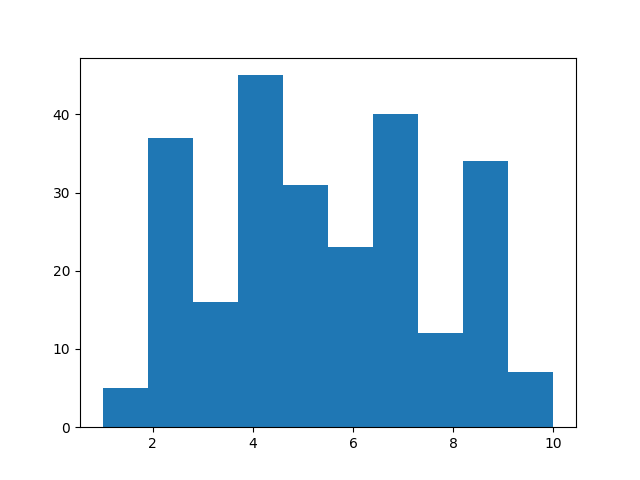

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.hist(fa.df['rb'])

In [9]:
fa.df[['smiles', 'zinc_id']].to_csv('filtered.smi', header=False, sep=' ', index=False)